In [76]:
import numpy as np
import torch
from torchvision.utils import make_grid

from loader.MNIST_dataset import MNIST_dataset
from models.ae import AE
from models.modules import FC_image

import matplotlib.pyplot as plt
import copy


# if you don't have gpu, 
# you can set device='cpu'
device = f'cuda:0'

- In this exercise, you will study how to analyze MNIST image data that approximately lies on some low-dimensional manifold. 
- Here, we assume the manifold's dimension is 2 for visualization purpose. 
- For simplicity, we use MNIST image of digits 0, 1, 2, 3, 4


1. Load Dataset (MNIST digits 0, 1, 2, 3, 4)

- The script below automatically downloads the MNIST image data in "datasets" directory.
- The image size is (1, 28, 28) which can be viewed as a data point living in $\mathbb{R}^{784}$.

In [2]:
train_ds = MNIST_dataset(root='datasets', split='training', digits=[0, 1, 2, 3, 4])

/home/robotics/anaconda3/envs/HarmonicAE/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


MNIST split training | torch.Size([25525, 1, 28, 28])


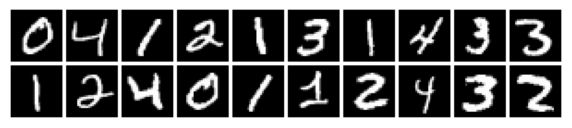

In [3]:
test_x = train_ds.data[:20]
x_img = make_grid(test_x, nrow=10, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

2. Load Pretrained Model

- You should download the pre-trained model "MNIST_digits_01234.pkl" from [HERE](https://drive.google.com/file/d/1nUB6IcvMFxEguH42ZmvamU2oY1iYHQKS/view?usp=sharing) and put it in the "pretrained/HW1/" directory. 
- The torch.nn.Module class "AE" has the two main methods "encode" and "decode", each of which corresponds to the encoder and decoder.

In [4]:
encoder = FC_image(in_chan=784, out_chan=2, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='linear') 
decoder = FC_image(in_chan=2, out_chan=784, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='sigmoid')

pretrained_model = AE(encoder, decoder)
pretrained_model.load_pretrained('pretrained/HW1/MNIST_digits_01234.pkl')
pretrained_model.to(device);

3. Visualize Embeddings

- Data points are mapped to the two-dimensioanl latent space (or coordinate space) by the encoder and visualized with label-coded colors.

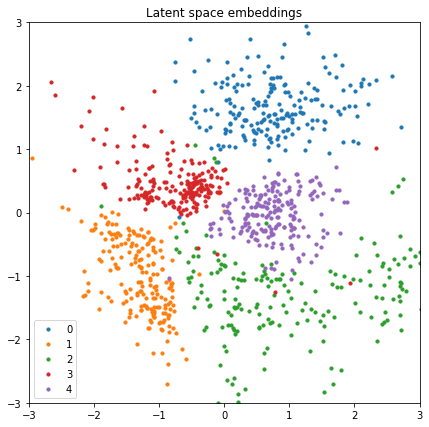

In [5]:
latent_embeddings = pretrained_model.encode(train_ds.data.to(device)).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

### Problem

(a) Write the code for computing the Riemannian metric expressed in the latent space.

In [6]:
def get_Riemannian_metric(f, z, create_graph=False):
    '''
    f:      pretrained_model.decode
    z:      torch.tensor whose size = (n, 2)
    out:    torch.tensor whose size = (n, 2, 2)
    '''
    def jacobian_of_decoder(f, z, create_graph=False):
        batch_size, z_dim = z.size()
        
        v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
        z = z.repeat(1, z_dim).view(-1, z_dim)
        out = (
            torch.autograd.functional.jvp(
                f, z, v=v, create_graph=create_graph
            )[1].view(batch_size, z_dim, -1).permute(0, 2, 1)
        )
        return out 
    J = jacobian_of_decoder(f, z, create_graph=create_graph)
    out = torch.einsum('nij,nik->njk', J, J)
    return out

- Your function "get_Riemannian_metric" should pass the below test code.

In [7]:
test_z = torch.randn(100, 2).to(device)

G = get_Riemannian_metric(pretrained_model.decode, test_z)
assert (G.size() == torch.Size([100, 2, 2]))

rand_v = torch.randn(100, 2).to(device)
assert torch.einsum('ni, nij, nj -> n', rand_v, G, rand_v).min().item() > 0

- With the "get_Riemannian_metric" function that you wrote, the below code will visualize the Riemannian metrics evaluated at some randomly selected points as equidistant ellipses, where the equidistant ellipse is defined as follows: given a Riemannian metric $G(z)$ at $z$, the equidistant ellipse at $z$ is a set $\{z' \ | \ (z'-z)^T G(z) (z'-z) = c\}$ for some constant $c>0$.  

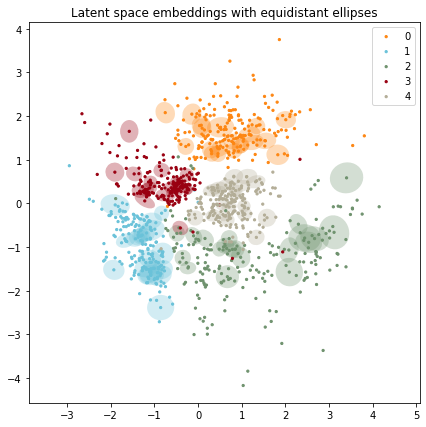

In [8]:
from utils import visualize_Riemannian_metric_as_ellipses

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
    
visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device)

Q1) Can you interpret this result?

- Now let's select class boundary points and visualize equidistant ellipses there.

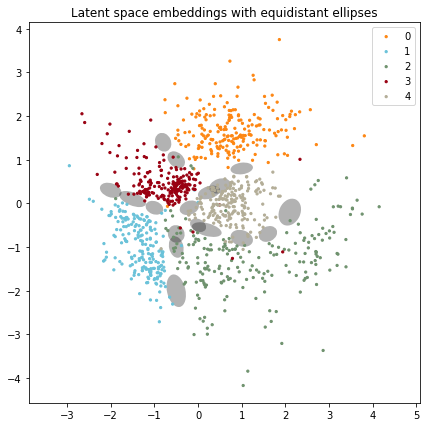

In [9]:
bd_points = torch.tensor([
    [-2, 0.3],
    [-1.5, 0.1],
    [-1, -0.1],
    [-0.5, -0.7],
    [-0.5, -1],
    [-0.5, -2],
    [0, -0.5],
    [0.2, -0.6],
    [1, -0.8],
    [1.6, -0.7],
    [2.1, -0.2],
    [-0.2, -0.1],
    [0.25, 0.25],
    [0.5, 0.4],
    [1, 0.8],
    [-0.5, 1],
    [-0.8, 1.4],
    ], dtype=torch.float32).to(device)

visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device,
    at=bd_points)

Q2) In which directions are the ellipses longer? Can you interpret this result?

(b) Write the code for computing the legnth of a curve $z(t) \in \mathbb{R}^{2}$ for $t\in[0,1]$ which corresponds to a curve on the two-dimensional MNIST data manifold, by using the "get_Riemannian_metric" function.

In [10]:
def compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric):
    '''
    curve:  torch.tensor whose size = (L, 2)
    out:    torch.tensor whose size = (1)
    '''
    dt = 1/(len(curve)-1)
    velocity = (curve[:-1] - curve[1:])/dt
    G = get_Riemannian_metric(pretrained_model.decode, curve[:-1])
    out = torch.sqrt(torch.einsum('ni, nij, nj -> n', velocity, G, velocity)).sum() * dt
    return out

- Your function should pass the below test code.

In [11]:
x1 = test_x[0:1]
x2 = test_x[1:2]

z1 = pretrained_model.encode(x1.to(device))
z2 = pretrained_model.encode(x2.to(device))

list_len = []
for num_discretization in [100, 1000]:
    z_curve = torch.cat([z1 + (z2 - z1) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    L = compute_length_of_curve(z_curve, pretrained_model, get_Riemannian_metric).item()
    list_len.append(L)
assert ((list_len[0] - list_len[1])/list_len[0] < 0.1)

- Now, you will compare the lengths of two curves whose lengths are same in the latent space.
- Below, the red and green squares correspond to digit 2 images and the blue square corresponds to digit 4 image.

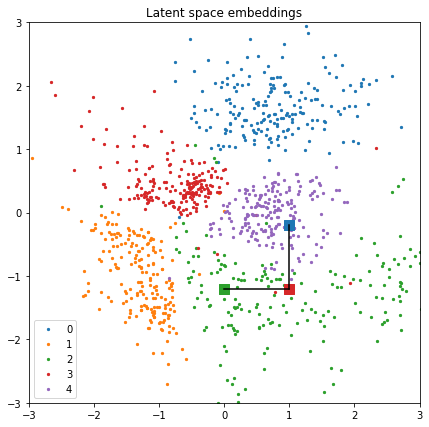

In [12]:
z1 = torch.tensor([[1, -1.2]], dtype=torch.float32) # digit 2 (red)
z2 = torch.tensor([[0, -1.2]], dtype=torch.float32) # digit 2 (green)
z3 = torch.tensor([[1, -0.2]], dtype=torch.float32) # digit 4 (blue)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s', s=100)
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s', s=100)
plt.scatter(z3[0, 0], z3[0, 1], c='tab:blue', marker='s', s=100)

plt.plot((z1[0, 0], z2[0, 0]), (z1[0, 1], z2[0, 1]), c='k')
plt.plot((z1[0, 0], z3[0, 0]), (z1[0, 1], z3[0, 1]), c='k')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

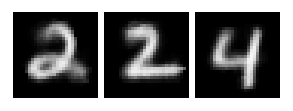

In [13]:
x1 = pretrained_model.decode(z1.to(device)) # red
x2 = pretrained_model.decode(z2.to(device)) # green 
x3 = pretrained_model.decode(z3.to(device)) # blue

x_img = make_grid(
    torch.cat([x1, x2, x3], dim=0).detach().cpu(), 
    nrow=3, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(5,5))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()


- Compute the lengths of two curves, red2green and red2blue straight lines, by using the "compute_length_of_curve" function.

In [14]:
num_discretization = 100
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
z13_linear_curve = torch.cat([z1.to(device) + (z3.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

L12 = compute_length_of_curve(
    z12_linear_curve
    , pretrained_model, get_Riemannian_metric)
L13 = compute_length_of_curve(
    z13_linear_curve
    , pretrained_model, get_Riemannian_metric)
L12, L13

(tensor(11.2813, device='cuda:0'), tensor(15.5817, device='cuda:0'))

Q3) Which curve is longer? Why?

(c) Write the code for finding the geodesic curve that connects two points $z_1, z_2 \in \mathbb{R}^2$ by using your "get_Riemannian_metric" function.

In [15]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    from scipy.optimize import minimize
    class GeodesicFittingTool():
        def __init__(self, z1, z2, z_init, pretrained_model, get_Riemannian_metric, num_discretization, method, device=f"cuda:{0}"):
            self.z1 = z1
            self.z2 = z2
            self.pretrained_model = pretrained_model
            self.get_Riemannian_metric = get_Riemannian_metric
            self.num_discretization = num_discretization
            self.delta_t = 1/(num_discretization-1)
            self.device = device
            self.method = method
            self.z_init_input = z_init
            self.initialize()
            
        def initialize(self):
            self.z_init= self.z1.squeeze(0)
            self.z_final= self.z2.squeeze(0)
            dim = self.z_final.size(0)
            self.init_z = self.z_init_input.detach().cpu().numpy()
            self.z_shape = self.init_z.shape
            self.init_z_vec = self.init_z.flatten()

        def geodesic_loss(self, z): 
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1])
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            return loss.item()
        
        def jac(self, z):
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_torch.requires_grad = True
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1], create_graph=True)
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            loss.backward()
            z_grad = z_torch.grad
            return z_grad.detach().cpu().numpy().flatten()

        def callback(self, z):
            self.Nfeval += 1
            return print('{} th loss : {}'.format(self.Nfeval, self.geodesic_loss(z)))
            
        def BFGS_optimizer(self, callback=False, maxiter=1000):
            self.Nfeval = 0
            z0 = self.init_z_vec
            if callback == True:
                call = self.callback
            else:
                call = None
            res = minimize(
                self.geodesic_loss, 
                z0, 
                callback=call, 
                method=self.method,
                jac = self.jac,
                options = {
                    'gtol': 1e-10, 
                    'eps': 1.4901161193847656e-08, 
                    'maxiter': maxiter, 
                    'disp': True, 
                    'return_all': False, 
                    'finite_diff_rel_step': None}
                )
            self.res = res

    z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    
    tool = GeodesicFittingTool(z1, z2, z12_linear_curve[1:-1], pretrained_model, get_Riemannian_metric, num_discretization, 'BFGS', device=device)
    tool.BFGS_optimizer()
    z_torch = torch.tensor(tool.res['x'].reshape(tool.z_shape), dtype=torch.float32).to(device)
    out = torch.cat([tool.z_init.unsqueeze(0), z_torch, tool.z_final.unsqueeze(0)], dim=0)
    return out

- Your code should pass the below test code.

In [79]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])

         Current function value: 1161.859497
         Iterations: 57
         Function evaluations: 135
         Gradient evaluations: 124


- Compute the lengths of the geodesic curve (i.e., geodesic distances).

In [80]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12

tensor(33.3846, device='cuda:0')

- Let's compare the geodesic and linear interpolation results.
- The gray line is the linear interpolation in the latent space and the pink line is the geodesic interpolation. 

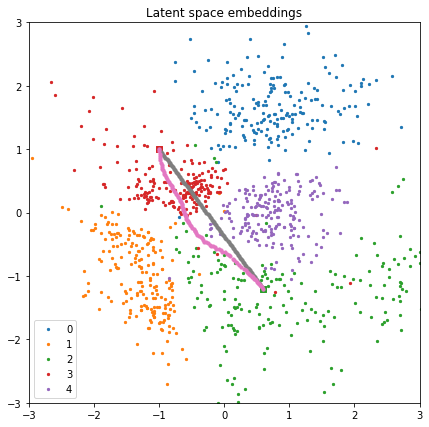

In [81]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

- Below visualizes the corresponding sequences of images.

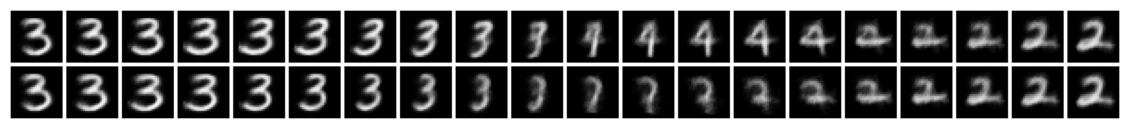

In [82]:
x12_linear_curve = pretrained_model.decode(z12_linear_curve)
x12_geodesic_curve = pretrained_model.decode(z12_geodesic_curve)

x_img = make_grid(
    torch.cat([
        x12_linear_curve[0:-1:5], 
        x12_geodesic_curve[0:-1:5]], dim=0).detach().cpu(), 
    nrow=20, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(20,20))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

Q4) How are they different? Why?

- Lastly, you will implement a clustering algorithm by using the geodesic distances and compare it with a usal Euclidean distance-based clustering algorithm in the latent sapce.
- We will use the SpectralClustering algorithm and only consider a subset of digit 2 and 4 images for simplicity. 

In [71]:
latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu()
data = []
targets = []
labels = [2, 4]

num_for_each_class = 20
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    data.append(classwise_le[:num_for_each_class])
    targets.append(train_ds.targets[train_ds.targets == label][:num_for_each_class])
data = torch.cat(data, dim=0)
targets = torch.cat(targets, dim=0)

In [74]:
from sklearn.cluster import SpectralClustering

## Euclidean clustering
SC = SpectralClustering(n_clusters=2)
SC.fit(data)
Euclidean_est = torch.tensor(SC.labels_)

## Geodesic clustering
num_data = len(data)
tau = 10000
affinity_matrix = np.eye(num_data)
for i in range(num_data):
    for j in range(i+1, num_data):
        z1 = data[i:i+1]
        z2 = data[j:j+1]
        z12_geodesic_curve = compute_geodesic(
            z1.to(device), 
            z2.to(device), 
            pretrained_model, 
            get_Riemannian_metric, 
            num_discretization=100)
        dist = compute_length_of_curve(
            z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
        affinity_matrix[i, j] = 2 * np.exp(-dist.item()**2/tau) 
        print(f'{i}-{j} done') 

affinity_matrix = (affinity_matrix + affinity_matrix.transpose())/2
SC = SpectralClustering(n_clusters=2, affinity='precomputed')
SC.fit(affinity_matrix)
Geodesic_est = torch.tensor(SC.labels_)

         Current function value: 60.033501
         Iterations: 53
         Function evaluations: 187
         Gradient evaluations: 179
0-1 done
         Current function value: 712.627502
         Iterations: 27
         Function evaluations: 102
         Gradient evaluations: 97
0-2 done
         Current function value: 1472.734863
         Iterations: 72
         Function evaluations: 133
         Gradient evaluations: 123
0-3 done
         Current function value: 301.828125
         Iterations: 52
         Function evaluations: 180
         Gradient evaluations: 168
0-4 done
         Current function value: 58.706184
         Iterations: 24
         Function evaluations: 96
         Gradient evaluations: 86
0-5 done
         Current function value: 78.738480
         Iterations: 63
         Function evaluations: 143
         Gradient evaluations: 133
0-6 done
         Current function value: 80.152657
         Iterations: 18
         Function evaluations: 97
         Gradient eval

Text(0.5, 1.0, 'Geodesic clustering result')

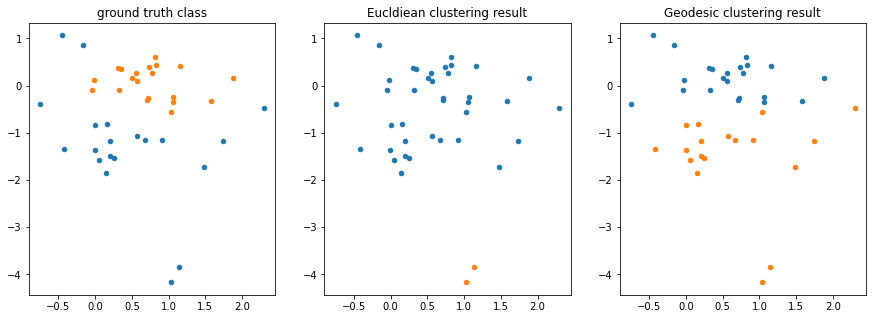

In [75]:
## plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for label in labels:
    classwise_le = data[targets == label]
    axes[0].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[0].set_title('ground truth class')

for label in [0, 1]:
    classwise_le = data[Euclidean_est == label]
    axes[1].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[1].set_title('Eucldiean clustering result')

for label in [0, 1]:
    classwise_le = data[Geodesic_est == label]
    axes[2].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[2].set_title('Geodesic clustering result')

Q5) Compare the results.

- To see more experiemnt results by using the latent space Riemannian metric, e.g., clustering with geodesic distances, chcek out the paper ["Latent Space Oddity: on the Curvature of Deep Generative Models"](https://arxiv.org/abs/1710.11379).